# School of Business Student Admission Chat

In [2]:
import os
import requests
import importlib
from typing import Literal
from dotenv import load_dotenv
from IPython.display import Image, display

from langgraph.prebuilt import create_react_agent
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

import utils
importlib.reload(utils)
from utils import *

load_dotenv()


True

# Tools

## Google Search

In [3]:
search = GoogleSerperAPIWrapper(k = 2)

# google_results = search.results("tuition site:https://business.wfu.edu/")

In [4]:
@tool
def google_search(query: str) -> str:
    """Conduct Search on Wake Forest MSBA Website for user question"""
    google_results = search.results(f'{query} site:business.wfu.edu/')
    documents = ggsearch_reformat(google_results)
    return documents

tools = [google_search]

# Simple Approach: Prebuilt ReAct Framework 

In this simple approach, we will basically provide the llm with access to the web search results and let it answer the questions.



In [5]:
model = ChatOpenAI(model = "gpt-4o", temperature = 0)

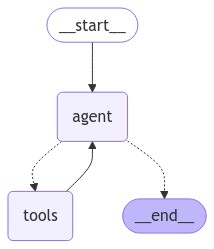

In [6]:
# integrate memory saver for the conversation 
memory = MemorySaver()


graph = create_react_agent(model, tools = tools, checkpointer = memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# since now we've memory built in, we need to define thread_id for each conversation 
config = {'configurable': {'thread_id': '3'}}

inputs = {"messages": [("user", "What is the MSBA program tuition?")]}
print_stream(graph.stream(inputs, stream_mode="values", config=config))

================================ Human Message =================================

What is the MSBA program tuition?
================================== Ai Message ==================================
Tool Calls:
  google_search (call_FErlBecmc6cEzohQwDP5J3CD)
 Call ID: call_FErlBecmc6cEzohQwDP5J3CD
  Args:
    query: MSBA program tuition site:wfu.edu
================================= Tool Message =================================
Name: google_search

[Document(metadata={'source': 'https://business.wfu.edu/masters-in-business-analytics/tuition-fees-living-expenses/', 'title': 'MSBA Tuition, Fees & Living Expenses'}, page_content='Tuition by Semester and Due Dates: ; Summer: $11,001 due early July ; Fall: $22,003 due August 1 ; Spring: $22,003 due December 1 ...'), Document(metadata={'source': 'https://business.wfu.edu/masters-in-business-analytics/financial-aid/', 'title': 'MSBA Tuition & Financial Aid'}, page_content='We have provided details below about tuition, scholarships and financia

`Conclusion`: This simple approach works well for answering questions that can be directly answered by the web search results. However, it may not be able to answer more complex questions that require deeper reasoning or interpretation of the information, also, it does not have memory of the previous conversation.

We need to scrape website to add more context to the conversation

so now, the tool will include both web search and web scraping. Web scrapping will scrape the website of the first result from the web search


but first of all, we need to recreate the react agent from scrach to understand more about the structure 

# Rebuild ReAct agent from scratch

In [8]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, AnyMessage
from langgraph.graph.message import add_messages, MessagesState


In [9]:
# define schema 

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# tool

@tool
def google_search(query: str) -> str:
    """Conduct Search on Wake Forest MSBA Website for user question"""
    # conduct basic web search
    google_results = search.results(f'{query} site:business.wfu.edu/')
    documents = ggsearch_reformat(google_results)
    # use jina to extract additional information from the first result
    link = documents[0].metadata['source']
    title = documents[0].metadata['title']
    jina_content = jina_scrape(link)
    documents.append(Document(page_content=jina_content, metadata={'source': link, 'title': title}))

    return documents

tools = [google_search]


## bind the tool with gpt-4o
model_with_tools = model.bind_tools(tools)


Now let's define nodes and edges. In our ReAct use case, there are only two nodes, one for call the model and one for using tools. 

In [10]:
import json 
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# Define the tool node
def tool_node(state: State):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])

        # Convert the Document objects to a serializable format
        if isinstance(tool_result, list) and all(isinstance(doc, Document) for doc in tool_result):
            # Convert each Document to a dictionary with relevant fields
            tool_result_serialized = [
                {
                    "metadata": doc.metadata,
                    "page_content": doc.page_content
                } for doc in tool_result
            ]
        else:
            tool_result_serialized = str(tool_result)  # Handle other types if not Document objects

        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result_serialized),  # Serialize the tool result
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Define the node that calls the model
def call_model(state: State, config: RunnableConfig):
    system_prompt = SystemMessage(
        """You are a helpful AI assistant, please respond to the users query to the best of your ability. You get access to Wake Forest school of Business tools which allow you explore all information on the website. 
        So if users ask question related to Wake Forest School of Business program or something related to that, use the tool to collect more relevant information """
    )
    
    # Ensure all messages are formatted as dictionaries with 'role' and 'content'
    formatted_messages = [
        {"role": msg[0], "content": msg[1]} if isinstance(msg, tuple) else msg
        for msg in state['messages']
    ]
    
    # Invoke the model with formatted messages
    response = model_with_tools.invoke([system_prompt] + formatted_messages, config)
    
    # Return the response as part of the 'messages' key in a list
    return {'messages': [response]}

# Define a conditional edge whether we should continue to use the tool or end
def should_continue(state: State):
    # If there was no tool call in the last message, end the conversation
    if not state['messages'][-1].tool_calls:
        return "end"
    else:
        return "continue"


Once we have defined all the needed function, we can define and compile our graph

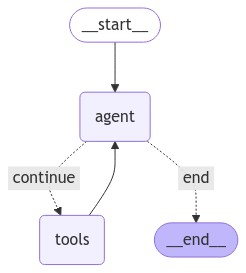

In [11]:
from langgraph.graph import StateGraph, START, END

# define a graph 

workflow = StateGraph(State)

# define nodes

workflow.add_node('agent', call_model)
workflow.add_node('tools', tool_node)

# add edges
workflow.add_edge(START, 'agent')
workflow.add_conditional_edges('agent', should_continue, {'continue': 'tools', 'end': END})
workflow.add_edge('tools', 'agent')

# add memory
memory = MemorySaver()

# compile the graph 
compiled_graph = workflow.compile(checkpointer=memory)

# visualize the graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))





In [12]:
config = {'configurable': {'thread_id': '3'}}
inputs = {"messages": [("user", "what is the MSBA tuition")]}
print_stream(compiled_graph.stream(inputs, config= config, stream_mode="values"))


================================ Human Message =================================

what is the MSBA tuition
================================== Ai Message ==================================
Tool Calls:
  google_search (call_TrrYBGVRRnIA3pWrl26qi5mf)
 Call ID: call_TrrYBGVRRnIA3pWrl26qi5mf
  Args:
    query: MSBA tuition Wake Forest School of Business
================================= Tool Message =================================
Name: google_search

[{"metadata": {"source": "https://business.wfu.edu/masters-in-business-analytics/tuition-fees-living-expenses/", "title": "MSBA Tuition, Fees & Living Expenses"}, "page_content": "2024-2025 Cost of Attendance (MSBA) ; Full Tuition(1), $55,007 ; Required Activity/Health Services Fee(2), $1,172 ; Estimated Living Expenses(3), Annual Amount."}, {"metadata": {"source": "https://business.wfu.edu/masters-in-business-analytics/financial-aid/", "title": "MSBA Tuition & Financial Aid"}, "page_content": "Financing Your Masters in Business Analytics. T

In [31]:
# Run
config = {'configurable': {'thread_id': '3'}}
messages = compiled_graph.invoke({"messages": 'what is the MSBA tuition'},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the MSBA tuition
================================== Ai Message ==================================
Tool Calls:
  google_search (call_9S18JTzdWGIfY2HWhJ76eLaU)
 Call ID: call_9S18JTzdWGIfY2HWhJ76eLaU
  Args:
    query: MSBA tuition site:wfu.edu
================================= Tool Message =================================
Name: google_search

[{"metadata": {"source": "https://business.wfu.edu/masters-in-business-analytics/tuition-fees-living-expenses/", "title": "MSBA Tuition, Fees & Living Expenses"}, "page_content": "Tuition is reviewed annually and subject to a 3% to 5% increase. Health insurance is required by the University for all students and offered as an option ..."}, {"metadata": {"source": "https://business.wfu.edu/masters-in-business-analytics/financial-aid/", "title": "MSBA Tuition & Financial Aid"}, "page_content": "We have provided details below about tuition, scholarships and finan

In [32]:
messages = compiled_graph.invoke({"messages": 'what courses are taught in the program?'},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the MSBA tuition
================================== Ai Message ==================================
Tool Calls:
  google_search (call_9S18JTzdWGIfY2HWhJ76eLaU)
 Call ID: call_9S18JTzdWGIfY2HWhJ76eLaU
  Args:
    query: MSBA tuition site:wfu.edu
================================= Tool Message =================================
Name: google_search

[{"metadata": {"source": "https://business.wfu.edu/masters-in-business-analytics/tuition-fees-living-expenses/", "title": "MSBA Tuition, Fees & Living Expenses"}, "page_content": "Tuition is reviewed annually and subject to a 3% to 5% increase. Health insurance is required by the University for all students and offered as an option ..."}, {"metadata": {"source": "https://business.wfu.edu/masters-in-business-analytics/financial-aid/", "title": "MSBA Tuition & Financial Aid"}, "page_content": "We have provided details below about tuition, scholarships and finan